In [151]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
site = 'site_6'

In [153]:
df_sensor_data = pd.read_pickle(f'./audio_data/{site}.pkl', compression='gzip')
df_device_data=pd.read_json(f'./audio_data/{site}.json')
df_sensor_data.loc[:, 'timestamp'] = (pd.to_datetime(df_sensor_data['timestamp'], utc=True)
                                 .dt.tz_convert('Europe/Helsinki')
                                 .dt.tz_localize(None))
df_sensor_data.loc[:,'timestamp'] = df_sensor_data.loc[:,'timestamp'] - df_sensor_data.loc[0,'timestamp']
df_sensor_data.loc[:,'timestamp'] = df_sensor_data.loc[:,'timestamp'].dt.total_seconds()
df_sensor_data['nodeid']=df_sensor_data['deviceid'].astype(str)+np.array(["_"])+df_sensor_data['timestamp'].astype(str)

In [154]:
import numpy as np
def calc_dist(x1,y1,x2,y2):
    return np.sqrt(np.square(x1-x2)+np.square(y1-y2))

In [155]:
audio_devices=df_device_data[df_device_data.index>151]
devices=df_device_data[df_device_data.index<=151]
devices=devices.drop_duplicates()

In [156]:
distances=pd.DataFrame()
for (i,row) in enumerate(audio_devices.iterrows()):
    print(row)
    x1=row[1][1]
    y1=row[1][2]
    #calc_dist(x1,y1,x['x'],x['y']
    dist=devices.apply(lambda x: [calc_dist(x1,y1,x['x'],x['y']), x['deviceid']],axis=1,result_type='expand')
    dist=dist.rename(columns={0:'dist',1:'deviceid'})
    dist['audioDevice']=row[1][0]
    distances=distances.append(dist)

(152, deviceid    audio_sensor_4
x               903.212359
y              1065.803693
Name: 152, dtype: object)
(153, deviceid    audio_sensor_2
x              1325.483386
y               672.277047
Name: 153, dtype: object)
(154, deviceid    audio_sensor_1
x               895.412256
y               677.966359
Name: 154, dtype: object)
(155, deviceid    audio_sensor_3
x              1334.579512
y              1059.567587
Name: 155, dtype: object)


In [157]:
res=distances.sort_values(by=['audioDevice','dist'])
max_dist=400
res=res[res['dist']<max_dist]


In [158]:
res.reset_index().to_json('distances.json')

In [159]:
distances2=pd.DataFrame()
for (i,row) in enumerate(devices.iterrows()):
    print(row)
    x1=row[1][1]
    y1=row[1][2]
    #calc_dist(x1,y1,x['x'],x['y']
    dist=devices.apply(lambda x: [calc_dist(x1,y1,x['x'],x['y']), x['deviceid']],axis=1,result_type='expand')
    dist=dist.rename(columns={0:'dist',1:'deviceid'})
    dist['deviceid2']=row[1][0]
    distances2=distances2.append(dist)

(0, deviceid              0
x           1790.285098
y            923.572858
Name: 0, dtype: object)
(1, deviceid             1
x           590.737646
y             912.4048
Name: 1, dtype: object)
(2, deviceid             2
x           1696.70291
y           789.411451
Name: 2, dtype: object)
(3, deviceid             3
x           935.481811
y           714.843439
Name: 3, dtype: object)
(4, deviceid             4
x           893.137033
y           782.859573
Name: 4, dtype: object)
(5, deviceid              5
x           1138.913842
y            310.652094
Name: 5, dtype: object)
(6, deviceid              6
x           1866.763718
y            674.210355
Name: 6, dtype: object)
(7, deviceid              7
x           1789.860343
y            1057.31595
Name: 7, dtype: object)
(8, deviceid              8
x           1695.190823
y            179.769549
Name: 8, dtype: object)
(9, deviceid              9
x           1148.051177
y           1284.446977
Name: 9, dtype: object)
(10, devicei

In [160]:
def get_distance(sensorId, sensorId2):
    pass
    

In [161]:
def get_neighbors(sensorEvent):
    neighNodes=distances2[distances2['deviceid']==sensorEvent['deviceid']]
    neighNodes = neighNodes[neighNodes['dist']<300]
    #print(neighNodes)
    delta=10
    neighEvents = df_sensor_data[df_sensor_data['timestamp']>sensorEvent['timestamp']-delta]
    neighEvents = neighEvents[neighEvents['timestamp']<=sensorEvent['timestamp']+delta]
    #print(neighEvents)
    neighEvents = neighEvents[neighEvents['deviceid'].isin(neighNodes['deviceid2'])]
    print(neighEvents)
    i=0
    events=neighEvents.copy()
    distar=np.zeros(len(events))
    while i<len(neighEvents):
        event = neighEvents.iloc[i]
        #print(event)
        dist=neighNodes[neighNodes['deviceid2']==event['deviceid']]
        #print(len(dist))
        distar[i]=dist['dist']
        i=i+1
    #print(events)
    #print(events)
    #print(events['timestamp'])
    events['dist']=distar
    y1=events['timestamp']-sensorEvent['timestamp']
    events['timedist']=events['dist']+np.abs(y1)
    events=events[events['timedist']>0]
    events=events.sort_values(by=['dist'])
    return events

In [162]:
df_sensor_data.head()


timestamp  deviceid    nodeid
0      0.000         5     5_0.0
1      0.251         5   5_0.251
2      0.406        74  74_0.406
3      0.523        34  34_0.523
4      0.687        34  34_0.687

In [163]:
sensorEvent=df_sensor_data.iloc[2]
print(get_neighbors(sensorEvent))
print(sensorEvent)

    timestamp  deviceid                  nodeid
2       0.406        74                74_0.406
5       1.280       116                116_1.28
7       2.159       134  134_2.1590000000000003
8       2.368        51   51_2.3680000000000003
15      3.887        77   77_3.8870000000000005
16      4.119       103   103_4.119000000000001
    timestamp  deviceid                  nodeid        dist    timedist
8       2.368        51   51_2.3680000000000003  113.445834  115.407834
7       2.159       134  134_2.1590000000000003  221.939332  223.692332
15      3.887        77   77_3.8870000000000005  232.963567  236.444567
5       1.280       116                116_1.28  241.131083  242.005083
16      4.119       103   103_4.119000000000001  295.300636  299.013636
timestamp       0.406
deviceid           74
nodeid       74_0.406
Name: 2, dtype: object


In [164]:
import networkx as nx
G = nx.Graph()
nodeIds=df_sensor_data['nodeid']
G.add_nodes_from(nodeIds)


In [165]:
i=0
print(len(df_sensor_data))
while i<len(df_sensor_data):
    event=df_sensor_data.iloc[i]
    curnode=event['nodeid']
    neighbors=get_neighbors(event)
    bestNeighbor=None
    if(len(neighbors)>1):
        #print(neighbors)
        neighbors=neighbors[neighbors['timestamp']>event['timestamp']]
        if(len(neighbors)>0):
            j=0
            while j<len(neighbors):# and j<2:
                bestNeighbor=neighbors.iloc[j]
                neighNode=bestNeighbor['nodeid']
                #print("Adding node")
                G.add_edge(curnode,neighNode)
                G.add_edge(neighNode,curnode)
                j=j+1
    #print(i)
    i=i+1


913
    timestamp  deviceid                 nodeid
0       0.000         5                  5_0.0
1       0.251         5                5_0.251
3       0.523        34               34_0.523
4       0.687        34               34_0.687
6       2.024        20               20_2.024
9       2.395        38               38_2.395
10      2.487        86               86_2.487
11      2.759        33  33_2.7590000000000003
12      2.967        33               33_2.967
15      3.887        77  77_3.8870000000000005
16      4.119       103  103_4.119000000000001
    timestamp  deviceid                 nodeid
0       0.000         5                  5_0.0
1       0.251         5                5_0.251
3       0.523        34               34_0.523
4       0.687        34               34_0.687
6       2.024        20               20_2.024
9       2.395        38               38_2.395
10      2.487        86               86_2.487
11      2.759        33  33_2.7590000000000003
12      2

In [166]:

comps=list(nx.connected_components(G))
#G.edges

In [167]:
comps[0]
print(comps[0])
inds=df_sensor_data['nodeid'].str.contains('103')
df_sensor_data[inds]

{'47_3.64', '33_2.7590000000000003', '38_2.395', '77_3.8870000000000005', '33_2.967', '20_2.024', '74_0.406', '131_3.129', '86_2.487', '116_1.28', '134_2.1590000000000003', '51_2.3680000000000003', '34_0.523', '5_0.0', '103_4.119000000000001', '34_0.687', '5_0.251'}


timestamp  deviceid                 nodeid
16      4.119000       103  103_4.119000000000001
457  1030.813983        36         36_1030.813983
458  1030.905196        63  63_1030.9051960000002
459  1031.245460        30          30_1031.24546
460  1035.545219        63         63_1035.545219
461  1036.472657       142        142_1036.472657
584  1300.103157        23         23_1300.103157

In [168]:
count=0
for index,comp in enumerate(comps):
    for sensor in comp:
        inds=df_sensor_data['nodeid']==sensor
        if(sum(inds)==0):
            print(sensor)
            count=count+1
            continue
        #print(sensor)
        print(sum(inds))
        df_sensor_data.loc[inds,'groupid']=index
        df_sensor_data.loc[inds,'groupsize']=len(comp)
count

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0

In [169]:
df_sensor_data=df_sensor_data.sort_values(by=['groupid','timestamp'])
df_sensor_data[df_sensor_data['groupid']==428]

Empty DataFrame
Columns: [timestamp, deviceid, nodeid, groupid, groupsize]
Index: []

In [170]:
df_sensor_data.to_json('sensor-data-with-groups.json')

KeyboardInterrupt: 

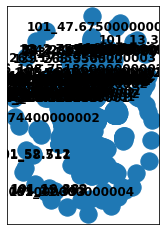

In [171]:
import matplotlib.pyplot as plt
subax1 = plt.subplot(121)
#nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')